<h2> Data Loading and Exploration </h2>

In [76]:
import numpy as np
import pandas as pd

In [77]:
nflplay = pd.read_csv(r"https://raw.githubusercontent.com/ryurko/nflscrapR-data/master/play_by_play_data/regular_season/reg_pbp_2018.csv")

In [78]:
nflplay.shape

(45156, 256)

In [79]:
nflplay["play_type"].unique()

array(['kickoff', 'no_play', 'pass', 'run', 'punt', 'field_goal', nan,
       'qb_kneel', 'extra_point', 'qb_spike'], dtype=object)

In [80]:
nflModel =  nflplay[["posteam","qtr","down","ydstogo","yardline_100","score_differential","half_seconds_remaining","play_type"]]
del nflplay

In [81]:
nflModel = nflModel[(nflModel["play_type"] == 'pass') | (nflModel["play_type"] == 'run') | (nflModel["play_type"] == 'field_goal') | (nflModel["play_type"] == 'punt')]

In [82]:
nflModel.dtypes

posteam                    object
qtr                         int64
down                      float64
ydstogo                     int64
yardline_100              float64
score_differential        float64
half_seconds_remaining    float64
play_type                  object
dtype: object

In [83]:
nflModel.describe()

,qtr,down,ydstogo,yardline_100,score_differential,half_seconds_remaining
count,34952.000000,34826.000000,34952.000000,34952.000000,34952.000000,34952.000000
mean,2.556363,1.979441,8.616445,51.488041,-1.454194,841.571841
std,1.131873,1.003673,4.190317,24.451912,10.811505,542.708363
min,1.000000,1.000000,0.000000,1.000000,-44.000000,0.000000
25%,2.000000,1.000000,6.000000,33.000000,-7.000000,343.750000
50%,3.000000,2.000000,10.000000,55.000000,0.000000,831.000000
75%,4.000000,3.000000,10.000000,72.000000,4.000000,1313.000000
max,5.000000,4.000000,46.000000,99.000000,44.000000,1800.000000


In [84]:
nflModel.dropna(axis = 0, how='any',inplace= True)

In [85]:
nflModel["down"] = nflModel["down"].astype(int)

<h2> Data Visualization </h2>

In [86]:
import matplotlib.pyplot as plt
import seaborn as sns

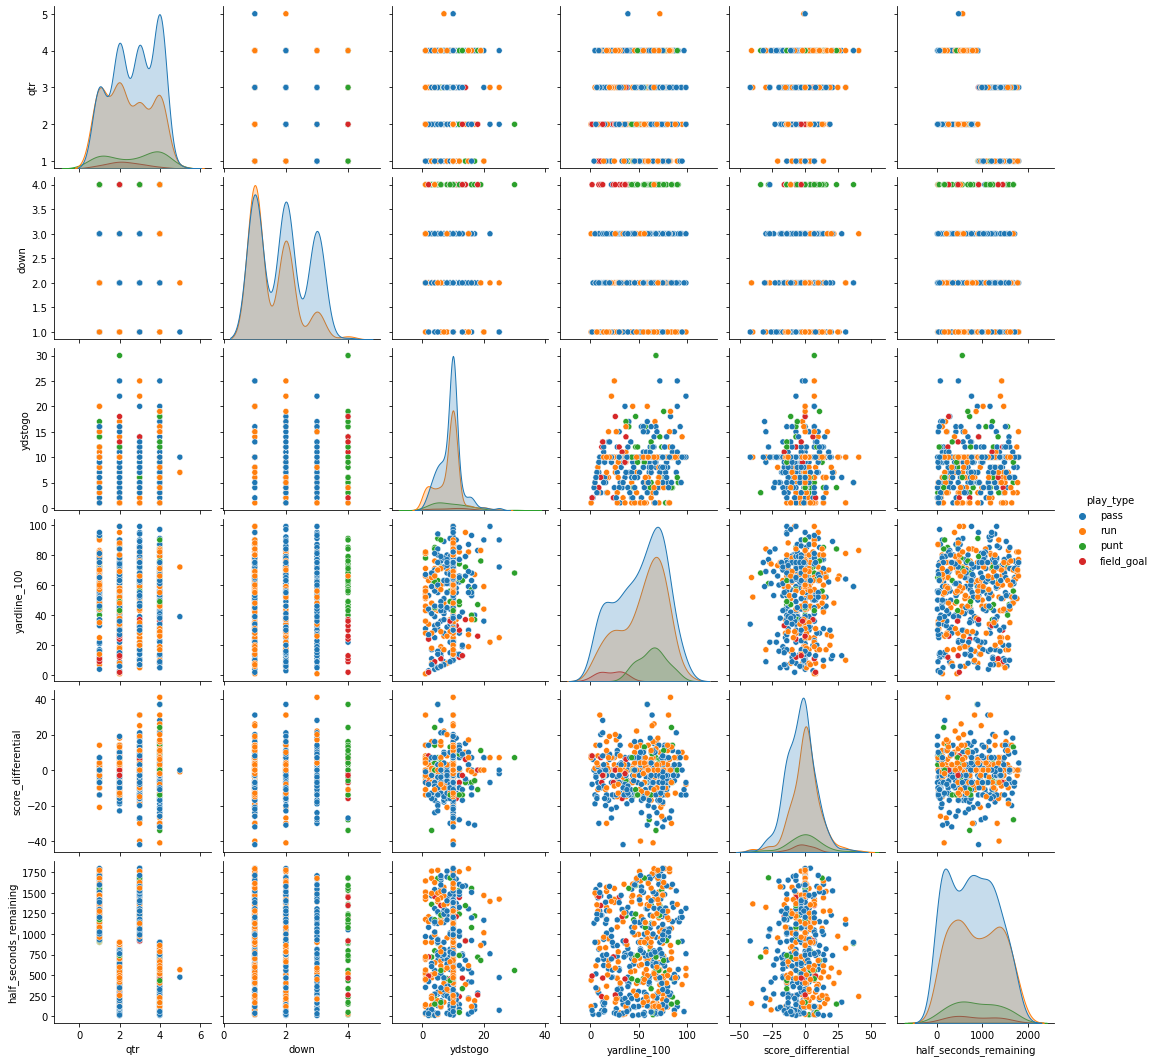

In [87]:
sns.pairplot(nflModel.sample(500, random_state=21), hue="play_type")

<h2> Test/Train Split </h2>

In [88]:
from sklearn.model_selection import train_test_split

In [89]:
X = nflModel.drop(["play_type","posteam"], axis = 1)
y = nflModel["play_type"]

In [90]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=21)

<h2> model building </h2>

In [91]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.inspection import permutation_importance


<h3> Baseline Model </h3>

In [92]:
from sklearn.dummy import DummyClassifier

In [93]:
dummy_clf = DummyClassifier(strategy="most_frequent")
y_dummy = dummy_clf.fit(X_train,y_train).predict(X_test)
accuracy_score(y_test, y_dummy)

0.5321561871949468

This baseline model tells us how accurate a model would be if it just predicted the most frequent predictor. The following model accuracy should be compared to this baseline.

<h3> Naive Bayes </h3>

In [94]:
from sklearn.naive_bayes import GaussianNB

In [95]:
gnb = GaussianNB()
gnbfit = gnb.fit(X_train, y_train)

In [96]:
y_pred = gnbfit.predict(X_test)

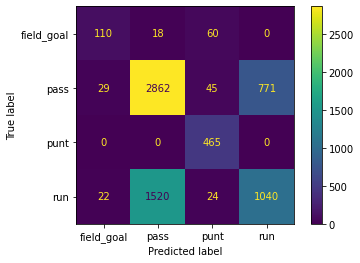

In [97]:
cm = confusion_matrix(y_test, y_pred, labels=gnb.classes_)

cm_display = ConfusionMatrixDisplay(cm, display_labels=gnb.classes_).plot()

plt.show()

In [98]:
accuracy_score(y_test, y_pred)

0.6426930806775768

The Naive Bayes model is an improvement over our base classifier; however, not by much. It does a good job predicted field goals and punts (prefect score!). There is some difficulty with passes and runs, which is to be expected.

<h3> Random Forest </h3>

In [99]:
from sklearn.ensemble import RandomForestClassifier

In [100]:
rfc = RandomForestClassifier()
rfcfit = rfc.fit(X_train, y_train)

In [101]:
y_pred = rfcfit.predict(X_test)

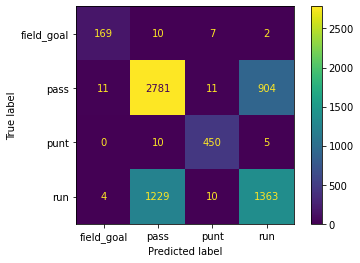

In [102]:
cm = confusion_matrix(y_test, y_pred, labels=rfc.classes_)

cm_display = ConfusionMatrixDisplay(cm, display_labels=rfc.classes_).plot()

plt.show()

In [103]:
accuracy_score(y_test, y_pred)

0.6837496411139822

In [104]:
result = permutation_importance(rfcfit, X_train, y_train)

In [105]:
result

{'importances_mean': array([0.17575018, 0.35318737, 0.20430725, 0.26853553, 0.28346734,
        0.26906676]),
 'importances_std': array([0.00194365, 0.00277804, 0.00087804, 0.00083829, 0.00096676,
        0.00122742]),
 'importances': array([[0.17767408, 0.1735822 , 0.17763819, 0.17659727, 0.17325915],
        [0.35186648, 0.35272793, 0.35559943, 0.34895908, 0.35678392],
        [0.20563532, 0.20470208, 0.20326633, 0.20452261, 0.20340991],
        [0.26931084, 0.26848528, 0.26748026, 0.26963388, 0.26776741],
        [0.284458  , 0.28395549, 0.2827351 , 0.28424264, 0.28194544],
        [0.26945441, 0.2695262 , 0.26787509, 0.26755205, 0.27092606]])}

In [106]:
X_train.columns

Index(['qtr', 'down', 'ydstogo', 'yardline_100', 'score_differential',
       'half_seconds_remaining'],
      dtype='object')

In [107]:
permutationimportanceDF = pd.DataFrame(dict(zip(X_train.columns,result['importances_mean'])), index=[0])
permutationimportanceDF

,qtr,down,ydstogo,yardline_100,score_differential,half_seconds_remaining
0,0.17575,0.353187,0.204307,0.268536,0.283467,0.269067


Both models are barely an improvement over the baseline model; however, the available variables have similar permutation importance. It may be necessary to include variables that were not in the original data set.

<h2> Include Passing Data </h2>

To improve the model, I want to determine how effective a team's quarter back and running back are to see if that influences the decision to run or pass.

In [108]:
import requests
from bs4 import BeautifulSoup
from pprint import pprint

I will be using beautiful soup to scrape data from Pro Football Reference.

In [109]:
url = r"https://www.pro-football-reference.com/years/2018/passing.htm"
r = requests.get(url)
    
if (r.status_code == 200):
    soup = BeautifulSoup(r.content, "html")

    table = soup.find(id="div_passing")

    header_row = table.find_all('tr')[0]

    header = []

    for each in header_row.findAll('th'):
        header.append(each.text)

    scraped_data = []

    for row in table.find_all('tr')[1:]:
        row_data = [x.text for x in row.children]
        scraped_data.append(dict(zip(header,row_data)))

    QBstats = pd.DataFrame(scraped_data)
    


In [110]:
QBstats = QBstats[QBstats["Tm"] != "\n"]

In [111]:
QBstats['Tm'].unique()

array(['PIT', 'KAN', 'ATL', 'LAR', 'IND', 'GNB', 'NWE', 'LAC', 'NYG',
       'MIN', 'HOU', 'OAK', 'NOR', 'DEN', 'DAL', 'DET', 'CLE', 'SEA',
       'CAR', 'CHI', 'PHI', 'TAM', 'NYJ', 'JAX', 'CIN', 'TEN', 'BAL',
       'ARI', 'SFO', 'WAS', 'BUF', 'MIA', '2TM'], dtype=object)

In [112]:
nflModel["posteam"].unique()

array(['ATL', 'PHI', 'BAL', 'BUF', 'JAX', 'NYG', 'NO', 'TB', 'NE', 'HOU',
       'MIN', 'SF', 'TEN', 'MIA', 'CIN', 'IND', 'PIT', 'CLE', 'LAC', 'KC',
       'DEN', 'SEA', 'DAL', 'CAR', 'WAS', 'ARI', 'GB', 'CHI', 'NYJ',
       'DET', 'OAK', 'LA'], dtype=object)

Our two team identifyers are not always the same. This needs to be resolved to merge.

In [113]:
namedict = {"LAR":"LA","GNB":"GB","SFO":"SF","TAM":"TB","NWE":"NE","NOR":"NO","KAN":"KC"}
QBstats = QBstats.replace({"Tm":namedict})

In [114]:
teamQBR = QBstats[["Tm","QBR"]].groupby("Tm").max()

<h2> Get Rushing Data </h2>

In [115]:
url = r"https://www.pro-football-reference.com/years/2018/rushing.htm"
r = requests.get(url)
    
if (r.status_code == 200):
    soup = BeautifulSoup(r.content, "html")

    table = soup.find(id="div_rushing")

    header_row = table.find_all('tr')[1]

    header = []

    for each in header_row.findAll('th'):
        header.append(each.text)

    scraped_data = []

    for row in table.find_all('tr')[2:]:
        row_data = [x.text for x in row.children]
        scraped_data.append(dict(zip(header,row_data)))

    RBstats = pd.DataFrame(scraped_data)

In [116]:
RBstats = RBstats.replace({"Tm":namedict})

In [117]:
RBstats = RBstats[RBstats["Tm"] != "\n"]

In [118]:
teamRBya = RBstats[["Tm","Y/A"]].groupby("Tm").max()

<h2> Merge Data </h2>

In [119]:
nflModel.shape

(34826, 8)

In [120]:
nflModel = nflModel.merge(teamQBR, how= 'inner', left_on="posteam", right_on="Tm")

In [121]:
nflModel = nflModel.merge(teamRBya,how= 'inner', left_on="posteam", right_on="Tm")

In [122]:
nflModel.head()

,posteam,qtr,down,ydstogo,yardline_100,score_differential,half_seconds_remaining,play_type,QBR,Y/A
0,ATL,1,1,15,80.0,0.0,1800.0,pass,65.7,7.9
1,ATL,1,2,5,70.0,0.0,1762.0,run,65.7,7.9
2,ATL,1,1,10,59.0,0.0,1726.0,run,65.7,7.9
3,ATL,1,1,10,39.0,0.0,1690.0,pass,65.7,7.9
4,ATL,1,2,10,39.0,0.0,1685.0,pass,65.7,7.9


<h2> Model Building with Additional Data </h2>

In [123]:
X = nflModel.drop(["play_type","posteam"], axis = 1)
y = nflModel["play_type"]

In [124]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=21)

In [125]:
gnb = GaussianNB()
gnbfit = gnb.fit(X_train, y_train)

In [126]:
y_pred = gnbfit.predict(X_test)

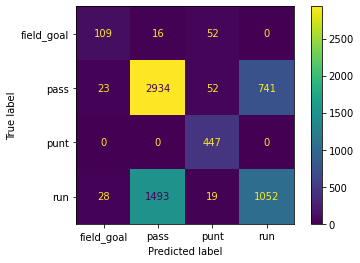

In [127]:
cm = confusion_matrix(y_test, y_pred, labels=gnb.classes_)

cm_display = ConfusionMatrixDisplay(cm, display_labels=gnb.classes_).plot()

plt.show()

In [128]:
accuracy_score(y_test, y_pred)

0.6520241171403962

In [129]:
rfc = RandomForestClassifier()
rfcfit = rfc.fit(X_train, y_train)

In [130]:
y_pred = rfcfit.predict(X_test)

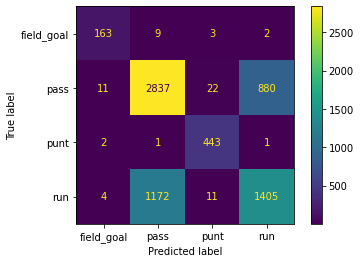

In [131]:
cm = confusion_matrix(y_test, y_pred, labels=rfc.classes_)

cm_display = ConfusionMatrixDisplay(cm, display_labels=rfc.classes_).plot()

plt.show()

In [132]:
accuracy_score(y_test, y_pred)

0.6959517657192076

In [133]:
result = permutation_importance(rfcfit, X_train, y_train)

In [134]:
permutationimportanceDF = pd.DataFrame(dict(zip(X_train.columns,result['importances_mean'])), index=[0])
permutationimportanceDF

,qtr,down,ydstogo,yardline_100,score_differential,half_seconds_remaining,QBR,Y/A
0,0.128808,0.328055,0.165793,0.207452,0.229038,0.193604,0.117021,0.118787


<h2> Hypertune Parameters </h2>

In [135]:
from sklearn.model_selection import GridSearchCV

In [156]:
parameters = {'n_estimators':[50,100,150,200],'max_depth':[None,6,7,8],'max_features':['sqrt', 'log2', None],'criterion':["gini","entropy","log_loss"]}

In [157]:
rfc = RandomForestClassifier()
clf = GridSearchCV(rfc, parameters, scoring='accuracy',n_jobs=-2)

In [158]:
clf.fit(X_train,y_train)

c:\users\josh\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.69400574 0.69684135 0.69544149 0.69619526 0.69497487 0.69684135
 0.69648241 0.69551328 0.68948313 0.6913855  0.69091888 0.69048816
 0.68366834 0.68395549 0.68352477 0.68427854 0.69260589 0.69393396
 0.6931084  0.69407753 0.68671931 0.68772434 0.68707825 0.6879397
 0.69271357 0.69343144 0.69149318 0.69282125 0.69831299 0.69938981
 0.69870782 0.69820531 0.69727207 0.69684135 0.69630294 0.69737976
 0.6971285  0.69863604 0.6988514  0.69935391 0.70333812 0.70430725
 0.70463029 0.70423546 0.70635319 0.70524049 0.70466619 0.70527638
 0.69389806 0.69382627 0.6954056  0.69641062 0.69332376 0.69730797
 0.69558507 0.69752333 0.69174444 0.69303661 0.69077531 0.69486719
 0.67562814 0.67616655 0.68072505 0.67706389 0.69163676 0.69242642
 0.69217516 0.69073941 0.6862168  0.68682699 0.68546303 0.68768844
 0.68833453 0.68898062 0.6

GridSearchCV(estimator=RandomForestClassifier(), n_jobs=-2,
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [None, 6, 7, 8],
                         'max_features': ['sqrt', 'log2', None],
                         'n_estimators': [50, 100, 150, 200]},
             scoring='accuracy')

In [159]:
print("The Best Score was {} and had these parameters {}".format(clf.best_score_,clf.best_params_))


The Best Score was 0.7063531945441494 and had these parameters {'criterion': 'gini', 'max_depth': 8, 'max_features': None, 'n_estimators': 50}


In [168]:
rfc = RandomForestClassifier(max_depth=8,max_features=None,n_estimators = 50, criterion='gini')
rfcfit = rfc.fit(X_train, y_train)

In [169]:
y_pred = rfcfit.predict(X_test)

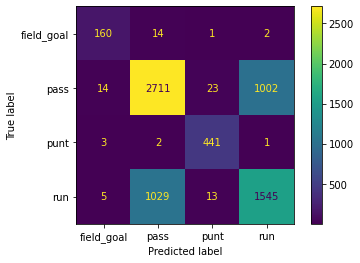

In [170]:
cm = confusion_matrix(y_test, y_pred, labels=rfc.classes_)

cm_display = ConfusionMatrixDisplay(cm, display_labels=rfc.classes_).plot()

plt.show()

In [171]:
accuracy_score(y_test, y_pred)

0.6972437553832903

Even with a hypertuned random forest we are not achieving even a 70% accuracy

<h2> Neural Network </h2>

In [147]:
from sklearn.neural_network import MLPClassifier

In [152]:
NNclf = MLPClassifier()
NNfit = NNclf.fit(X_train, y_train)

In [153]:
y_pred = NNfit.predict(X_test)

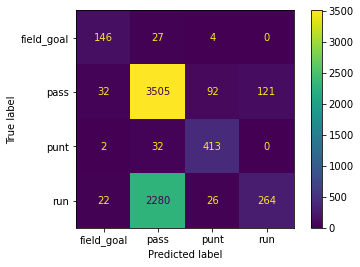

In [154]:
cm = confusion_matrix(y_test, y_pred, labels=rfc.classes_)

cm_display = ConfusionMatrixDisplay(cm, display_labels=rfc.classes_).plot()

plt.show()

In [155]:
accuracy_score(y_test, y_pred)

0.6213034740166523

<h2> Conclusion </h2>

Using various models and methods, we can very effectively predict punts and field goals. Predicting a pass play or run play proved much more difficult. Even trying to include ability metrics for passers and runners, we added very little additional accuracy to our test data set. Hypertuning the random forest also squeezed out a bit more accuracy, but we still are not producing results which are substantially better than just predicting the most frequent target variable. 

Additional data that might improve this model are metrics that could help determine how effective the defense's rush and pass defense are. 

If I were a coach for a team, I would not rely on this model, and would likely be better off relying on instinct and experience.

